In [ ]:
pip install yfinance

In [2]:
pip install pyportfolioopt

     |████████████████████████████████| 61 kB 7.9 MB/s 
     |████████████████████████████████| 2.8 MB 29.7 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

stocks = ["GS", "BCS", "MSFT", "PYPL", "GOOGL", "VOW3.DE", "ZS", "CRWD","AAPL", "SOFI"]

ohlc = yf.download(stocks, period="1Y")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AAPL,BCS,CRWD,GOOGL,GS,MSFT,PYPL,SOFI,VOW3.DE,ZS
Date,,,,,,,,,,
2021-10-29,149.800003,11.19,281.799988,2960.919922,413.350006,331.619995,232.589996,20.090000,193.820007,318.859985
2021-11-01,148.960007,11.18,269.170013,2869.939941,416.700012,329.369995,231.279999,22.620001,194.660004,318.679993
2021-11-02,150.020004,10.93,268.119995,2908.649902,423.850006,333.130005,229.460007,22.680000,193.440002,325.869995
2021-11-03,151.490005,11.15,270.649994,2931.959961,417.899994,334.000000,230.380005,22.959999,185.619995,327.500000
2021-11-04,150.960007,10.53,279.619995,2965.350098,408.070007,336.440002,228.220001,23.290001,187.800003,331.899994


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]


mcaps = {}
for t in stocks:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps



[*********************100%***********************]  1 of 1 completed


{'AAPL': 2476710297600,
 'BCS': 44257591296,
 'CRWD': 63807324160,
 'GOOGL': 1969526145024,
 'GS': 136618975232,
 'MSFT': 2525984718848,
 'PYPL': 268165349376,
 'SOFI': 18623383552,
 'VOW3.DE': 121519931392,
 'ZS': 46046478336}

AAPL       0.154496
BCS        0.034203
CRWD       0.105345
GOOGL      0.134105
GS         0.037564
MSFT       0.137051
PYPL       0.129812
SOFI       0.101844
VOW3.DE    0.047758
ZS         0.105472
dtype: float64

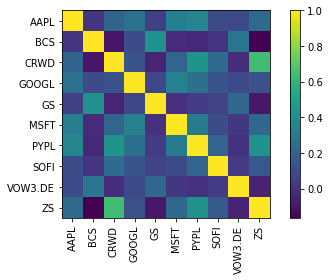

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta
plotting.plot_covariance(S, plot_correlation=True)

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior



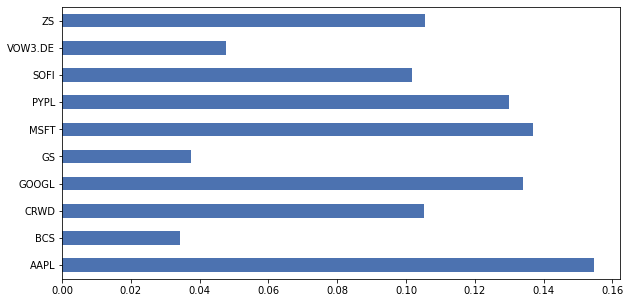

In [ ]:
market_prior.plot.barh(figsize=(10,5));

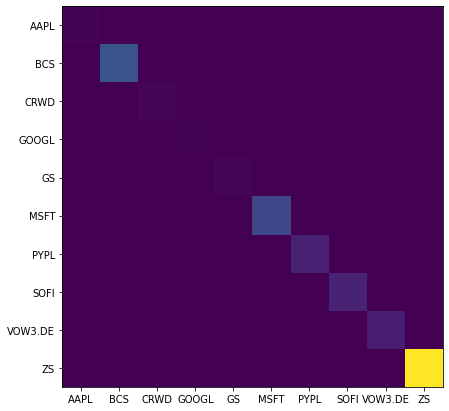

In [ ]:
from pypfopt import BlackLittermanModel

viewdict = {
    "GS": 0.08,
    "BCS": 0.01,
    "MSFT": 0.05,
    "PYPL": 0.05,
    "GOOGL" : 0.05,
    "VOW3.DE": 0.01,  
    "ZS": 0.10,
    "CRWD": 0.10,
    "AAPL": 0.04,  
    "SOFI": 0.35
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)


confidences = [
    0.8,
    0.2,
    0.6,
    0.9,
    0.7, 
    0.2,  
    0.5, 
    0.5,
    0.3,
    0.2
]

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

omega = np.diag(bl.omega)

In [ ]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=bl.omega)

ret_bl = bl.bl_returns()
ret_bl


rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df


,Prior,Posterior,Views
AAPL,0.154496,0.090824,0.04
BCS,0.034203,0.031992,0.01
CRWD,0.105345,0.078061,0.10
GOOGL,0.134105,0.064814,0.05
GS,0.037564,0.065700,0.08
MSFT,0.137051,0.068836,0.05
PYPL,0.129812,0.055063,0.05
SOFI,0.101844,0.117512,0.35
VOW3.DE,0.047758,0.029393,0.01
ZS,0.105472,0.073687,0.10


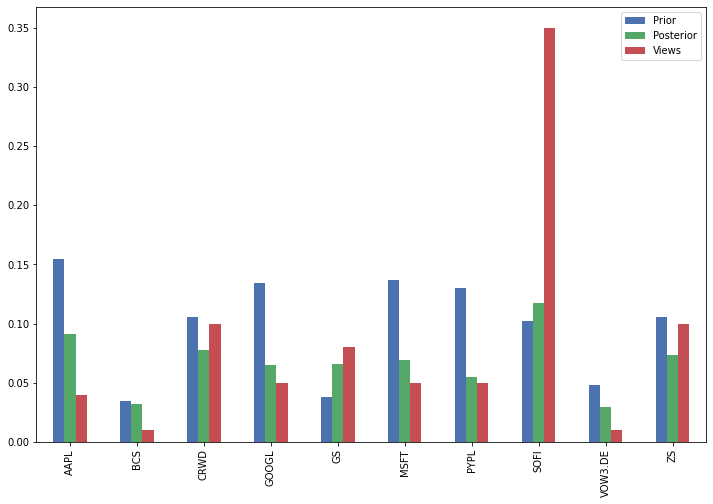

In [ ]:

rets_df.plot.bar(figsize=(12,8));

S_bl = bl.bl_cov()


from pypfopt import EfficientFrontier, objective_functions


ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)

weights = ef.clean_weights()
weights





In [ ]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()

weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AAPL', 0.17998),
             ('BCS', 0.02819),
             ('CRWD', 0.10593),
             ('GOOGL', 0.10797),
             ('GS', 0.12367),
             ('MSFT', 0.12099),
             ('PYPL', 0.05611),
             ('SOFI', 0.15882),
             ('VOW3.DE', 0.01761),
             ('ZS', 0.10074)])

In [ ]:

from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $1.85


{'AAPL': 118,
 'BCS': 243,
 'CRWD': 37,
 'GOOGL': 4,
 'GS': 29,
 'MSFT': 37,
 'PYPL': 23,
 'SOFI': 796,
 'VOW3.DE': 9,
 'ZS': 32}